# Estudo sobre Classificação de Tipos de Café

## 1. Sobre o Projeto

Nesse projeto, buscamos pesquisar e entender os padrões de vendas de café e a construção de algoritmos capazes de predizer o tipo de café baseado em características temporais, de preço e contexto de compra.
Para isso, utilizamos a base de dados de vendas de café com informações sobre horários, dias da semana, preços e tipos de pagamento.

Essa base de dados possui informações sobre vendas de café, com os seguintes atributos:
- Data e hora da venda
- Nome do café
- Preço (money)
- Tipo de pagamento (cash_type)
- Período do dia (Time_of_Day)
- Dia da semana (Weekday)
- Mês (Month_name)
- Ordenação temporal (Weekdaysort, Monthsort)
- Hora do dia (hour_of_day)

## 1.1 Metodologia

Como nosso objetivo principal é chegarmos a uma predição de tipos de café baseado em características de venda, iremos estabelecer algumas regras para execução desse estudo.

Para nos auxiliar com o estudo, iremos focar nas propriedades: hora do dia, preço, tipo de pagamento, período do dia, dia da semana, mês e características temporais extraídas.

## 1.2 Algoritmos Utilizados

Para auxiliar na predição do nosso modelo, utilizaremos três algoritmos de classificação diferentes:
- **K-Nearest Neighbors (KNN)**: Algoritmo baseado em proximidade que classifica baseado nos vizinhos mais próximos
- **Árvore de Decisão**: Algoritmo que cria uma estrutura de decisão em árvore para classificação
- **Random Forest**: Ensemble de árvores de decisão que combina múltiplas árvores para melhor precisão

Isso será importante para comparar diferentes abordagens de classificação e escolher o melhor modelo para nossos dados.

# 2. Algoritmo do projeto

### Variáveis globais

In [1]:
DATASET_PATH = "./dataset/Coffe_sales.csv"

## 2.1 Importação de bibliotecas

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

## 2.2 Atribuição da base de dados

In [3]:
df = pd.read_csv(DATASET_PATH)

print(f"Total de registros: {len(df)}")
print(f"Tipos de café únicos: {df['coffee_name'].nunique()}")
print(f"Faixa de preços: R${df['money'].min():.2f} - R${df['money'].max():.2f}")

df.head()

Total de registros: 3547
Tipos de café únicos: 8
Faixa de preços: R$18.12 - R$38.70


,hour_of_day,cash_type,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,Date,Time
0,10,card,38.7,Latte,Morning,Fri,Mar,5,3,2024-03-01,10:15:50.520000
1,12,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:19:22.539000
2,12,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:20:18.089000
3,13,card,28.9,Americano,Afternoon,Fri,Mar,5,3,2024-03-01,13:46:33.006000
4,13,card,38.7,Latte,Afternoon,Fri,Mar,5,3,2024-03-01,13:48:14.626000


# 3. Pré processamento de dados

Vamos preparar os dados criando a coluna DateTime e extraindo features temporais adicionais que podem ser úteis para a classificação.

In [4]:
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='mixed')

df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek  # 0=Monday, 6=Sunday
df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)

# Dividindo o range em 4 intervalos iguais
df['PriceRange'] = pd.cut(df['money'], 
                         bins=[18.12, 23.265, 28.41, 33.555, np.inf],  
                        labels=['Baixo', 'Medio', 'Alto', 'Premium'])


print("Features temporais criadas:")
print(f"- Hour: {df['Hour'].min()} a {df['Hour'].max()}")
print(f"- DayOfWeek: {df['DayOfWeek'].unique()}")
print(f"- IsWeekend: {df['IsWeekend'].value_counts().to_dict()}")
print(f"- PriceRange: {df['PriceRange'].value_counts().to_dict()}")

df.head()

Features temporais criadas:
- Hour: 6 a 22
- DayOfWeek: [4 5 6 0 1 2 3]
- IsWeekend: {0: 2658, 1: 889}
- PriceRange: {'Premium': 1466, 'Alto': 972, 'Medio': 806, 'Baixo': 267}


,hour_of_day,cash_type,money,coffee_name,Time_of_Day,Weekday,Month_name,Weekdaysort,Monthsort,Date,Time,DateTime,Hour,DayOfWeek,IsWeekend,PriceRange
0,10,card,38.7,Latte,Morning,Fri,Mar,5,3,2024-03-01,10:15:50.520000,2024-03-01 10:15:50.520,10,4,0,Premium
1,12,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:19:22.539000,2024-03-01 12:19:22.539,12,4,0,Premium
2,12,card,38.7,Hot Chocolate,Afternoon,Fri,Mar,5,3,2024-03-01,12:20:18.089000,2024-03-01 12:20:18.089,12,4,0,Premium
3,13,card,28.9,Americano,Afternoon,Fri,Mar,5,3,2024-03-01,13:46:33.006000,2024-03-01 13:46:33.006,13,4,0,Alto
4,13,card,38.7,Latte,Afternoon,Fri,Mar,5,3,2024-03-01,13:48:14.626000,2024-03-01 13:48:14.626,13,4,0,Premium


## 3.1 Análise Exploratória dos Dados

Análise dos Tipos de Café:
   Americano with Milk: 809 vendas (22.8%)
   Latte: 757 vendas (21.3%)
   Americano: 564 vendas (15.9%)
   Cappuccino: 486 vendas (13.7%)
   Cortado: 287 vendas (8.1%)
   Hot Chocolate: 276 vendas (7.8%)
   Cocoa: 239 vendas (6.7%)
   Espresso: 129 vendas (3.6%)


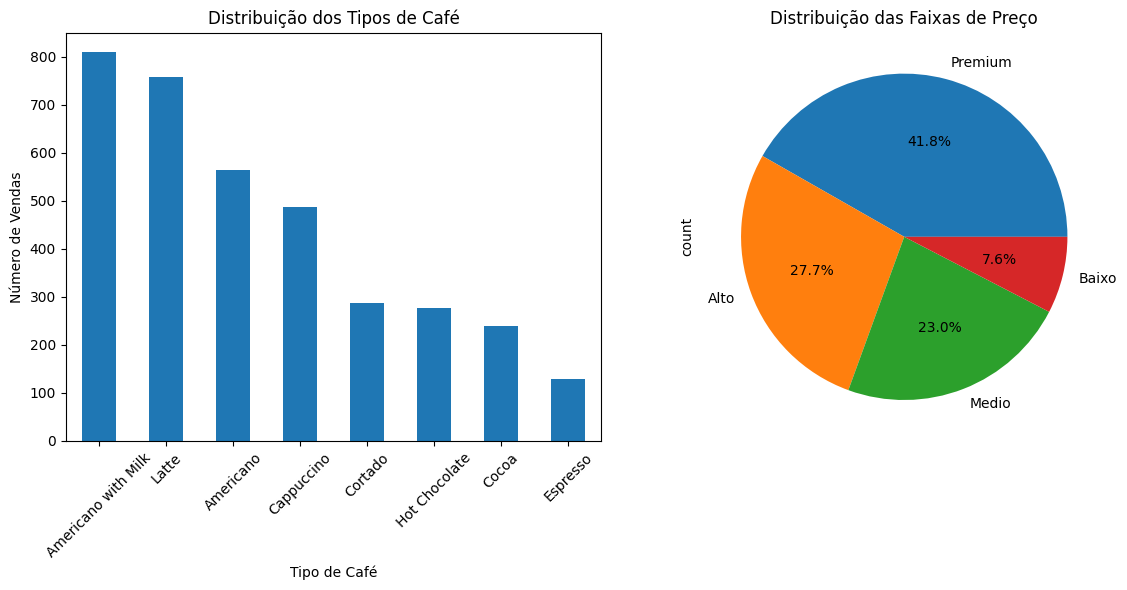

In [5]:
print("Análise dos Tipos de Café:")
coffee_counts = df['coffee_name'].value_counts()
for coffee, count in coffee_counts.items():
    print(f"   {coffee}: {count} vendas ({count/len(df)*100:.1f}%)")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
coffee_counts.plot(kind='bar')
plt.title('Distribuição dos Tipos de Café')
plt.xlabel('Tipo de Café')
plt.ylabel('Número de Vendas')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
df['PriceRange'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribuição das Faixas de Preço')
plt.tight_layout()
plt.show()

Agora iremos aplicar a codificação (Label Encoding) para as variáveis categóricas

In [6]:
encoders = {}
encoded_data = df.copy()

categorical_features = ['cash_type', 'Time_of_Day', 'Weekday', 'Month_name', 'PriceRange']

for feature in categorical_features:
    if feature in encoded_data.columns:
        le = LabelEncoder()
        encoded_data[feature + '_encoded'] = le.fit_transform(encoded_data[feature].astype(str))
        encoders[feature] = le

encoded_columns = [col for col in encoded_data.columns if '_encoded' in col]
encoded_data[['coffee_name'] + encoded_columns].head()

,coffee_name,cash_type_encoded,Time_of_Day_encoded,Weekday_encoded,Month_name_encoded,PriceRange_encoded
0,Latte,0,1,0,7,3
1,Hot Chocolate,0,0,0,7,3
2,Hot Chocolate,0,0,0,7,3
3,Americano,0,0,0,7,0
4,Latte,0,0,0,7,3


## 3.2 Preparação das Features para Modelagem

In [7]:
feature_columns = [
    'cash_type_encoded', 'Time_of_Day_encoded', 
    'Weekday_encoded', 'Month_name_encoded',
    'IsWeekend', 'PriceRange_encoded'
]

available_features = [col for col in feature_columns if col in encoded_data.columns]
missing_features = [col for col in feature_columns if col not in encoded_data.columns]

print(f"Features disponíveis: {len(available_features)}")
print(f"Features disponíveis: {available_features}")
if missing_features:
    print(f"Features não encontradas: {missing_features}")

X = encoded_data[feature_columns]
y = encoded_data['coffee_name']

print(f"\nShape dos dados:")
print(f"X (features): {X.shape}")
print(f"y (target): {y.shape}")
print(f"Classes únicas: {y.nunique()}")

Features disponíveis: 6
Features disponíveis: ['cash_type_encoded', 'Time_of_Day_encoded', 'Weekday_encoded', 'Month_name_encoded', 'IsWeekend', 'PriceRange_encoded']

Shape dos dados:
X (features): (3547, 6)
y (target): (3547,)
Classes únicas: 8


# 4. Criando algoritmos de classificação

Preparando os dados de teste e treinamento

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)


print(f"Tamanho do dataset completo: {len(encoded_data)}")
print(f"Tamanho do conjunto de treinamento: {len(X_train)} ({len(X_train)/len(encoded_data)*100:.1f}%)")
print(f"Tamanho do conjunto de teste: {len(X_test)} ({len(X_test)/len(encoded_data)*100:.1f}%)")
print(f"\nDistribuição de classes no conjunto de treinamento:")
print(y_train.value_counts())
print(f"\nDistribuição de classes no conjunto de teste:")
print(y_test.value_counts())

Tamanho do dataset completo: 3547
Tamanho do conjunto de treinamento: 3192 (90.0%)
Tamanho do conjunto de teste: 355 (10.0%)

Distribuição de classes no conjunto de treinamento:
coffee_name
Americano with Milk    728
Latte                  681
Americano              508
Cappuccino             437
Cortado                258
Hot Chocolate          249
Cocoa                  215
Espresso               116
Name: count, dtype: int64

Distribuição de classes no conjunto de teste:
coffee_name
Americano with Milk    81
Latte                  76
Americano              56
Cappuccino             49
Cortado                29
Hot Chocolate          27
Cocoa                  24
Espresso               13
Name: count, dtype: int64


## 4.1 K-Nearest Neighbors (KNN)

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

knn_predictions = knn_model.predict(X_test_scaled)
knn_accuracy = accuracy_score(y_test, knn_predictions)

print(f"KNN - Acurácia: {knn_accuracy:.4f}")

KNN - Acurácia: 0.5746


## 4.2 Árvore de Decisão

Decision Tree - Acurácia: 0.5634


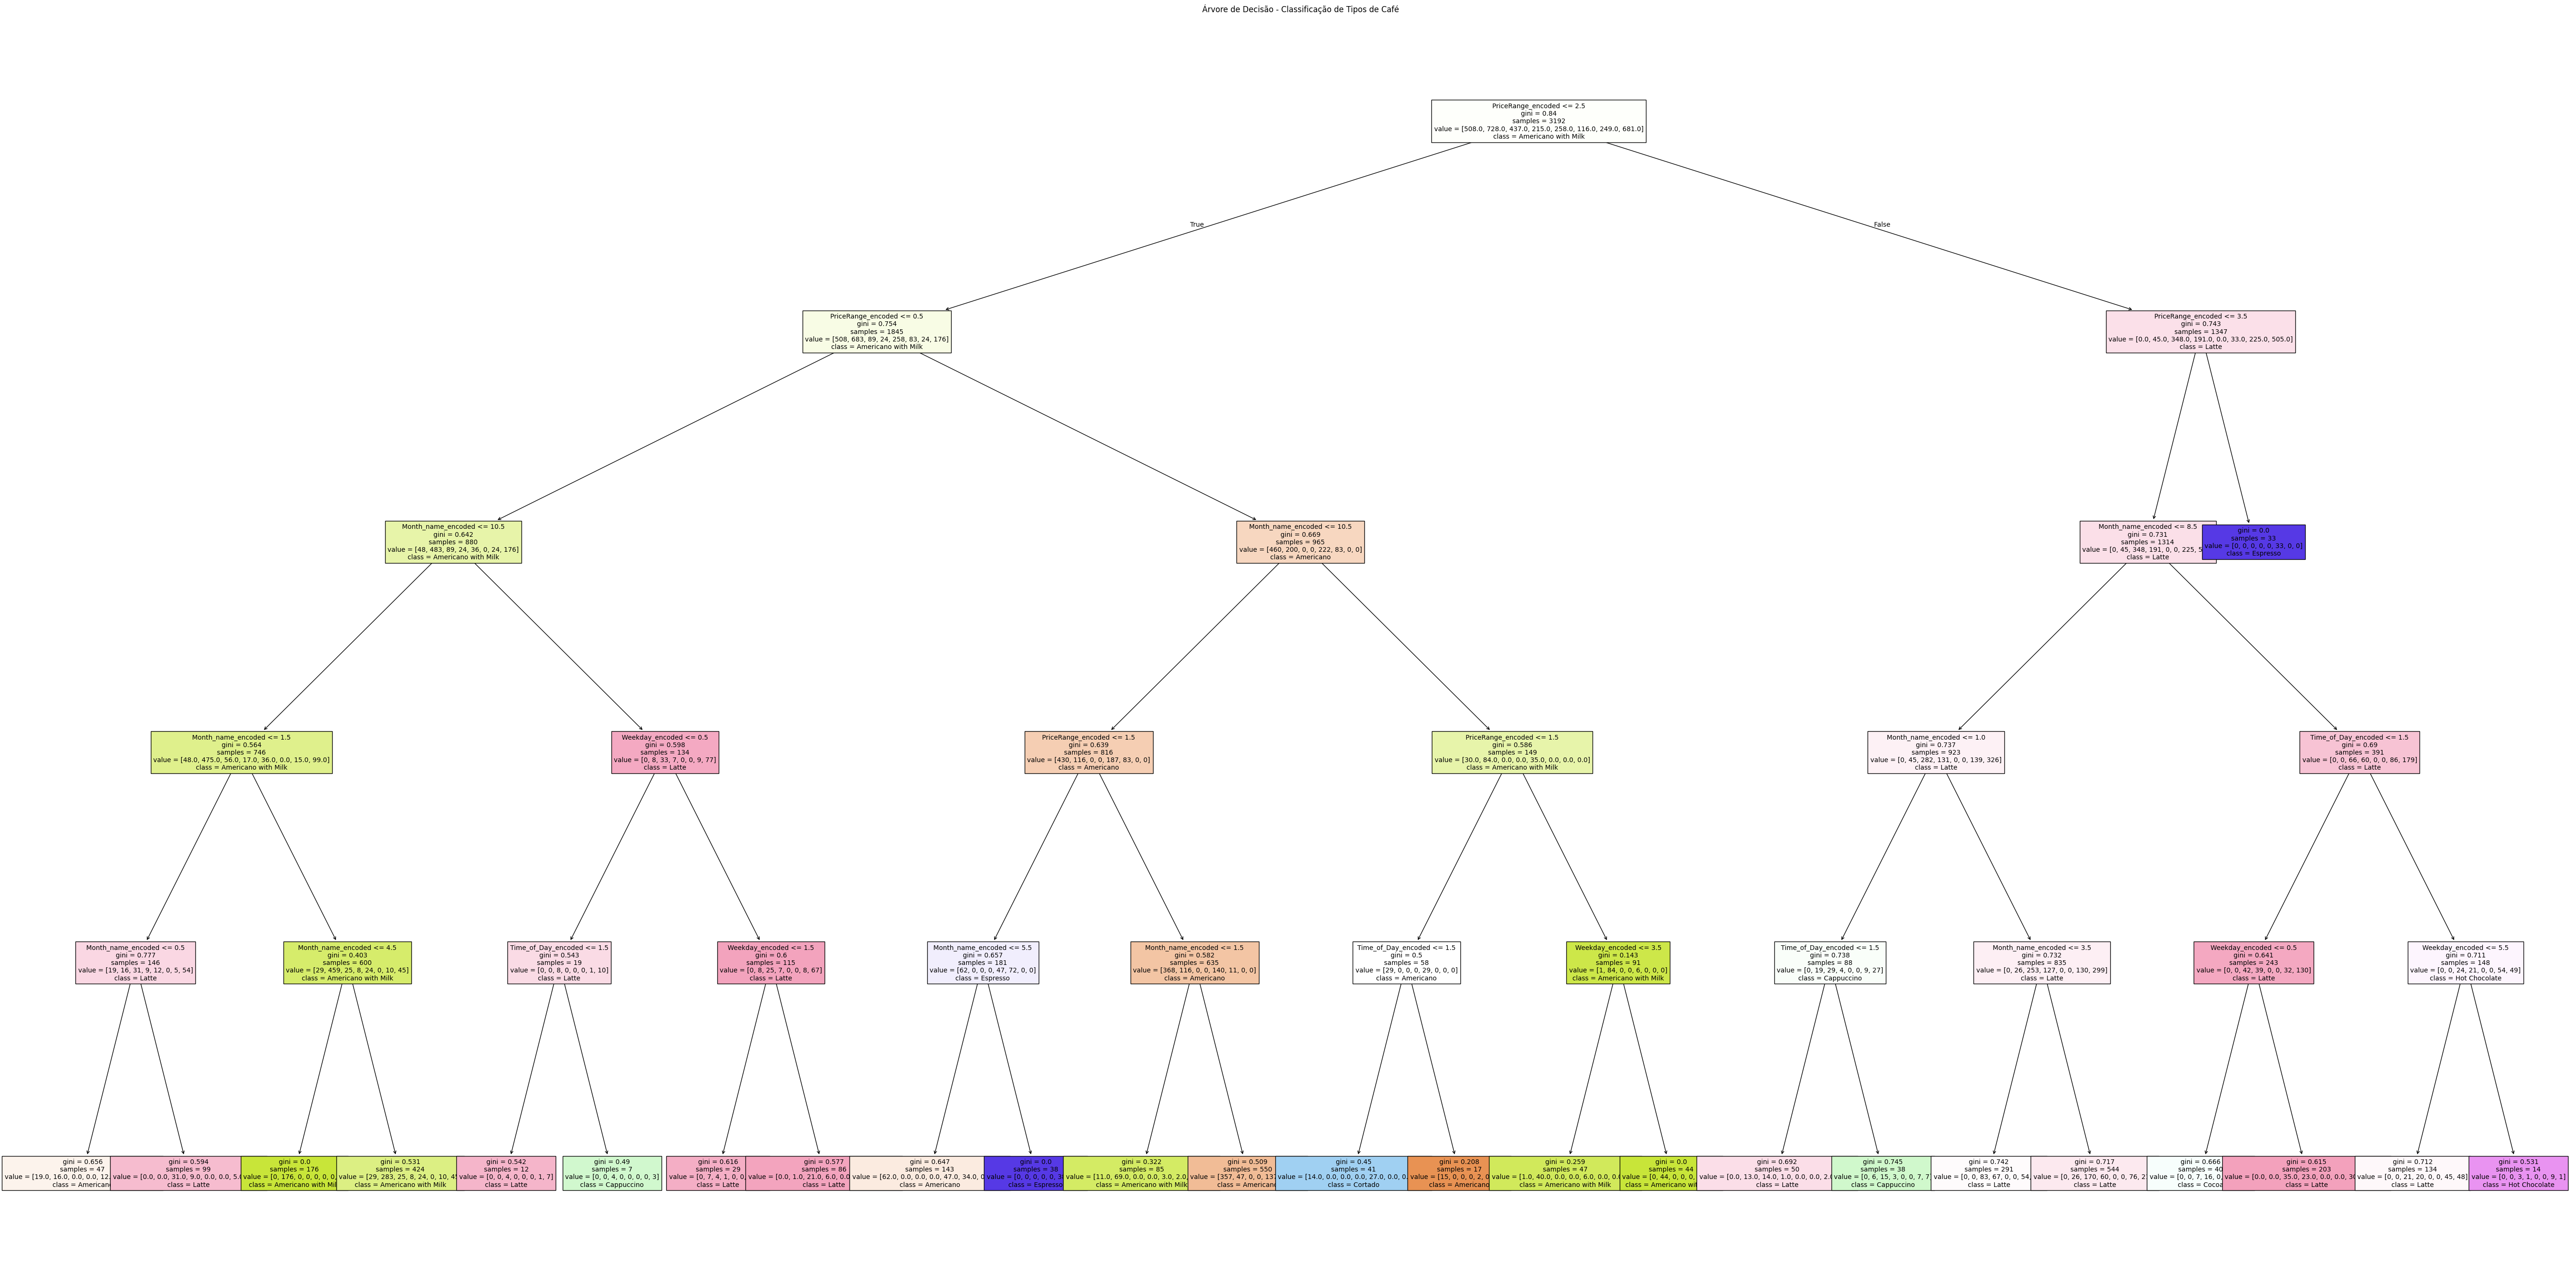

In [21]:
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)
dt_model.fit(X_train, y_train)

dt_predictions = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)

print(f"Decision Tree - Acurácia: {dt_accuracy:.4f}")

from sklearn.tree import plot_tree

plt.figure(figsize=(70, 35))
plot_tree(dt_model, feature_names=available_features, 
          class_names=dt_model.classes_, filled=True, fontsize=10, max_depth=5)
plt.title('Árvore de Decisão - Classificação de Tipos de Café')
plt.show()

## 4.3 Random Forest

Random Forest - Acurácia: 0.5972

Features mais importantes:
               feature  importance
5   PriceRange_encoded    0.500392
3   Month_name_encoded    0.337784
2      Weekday_encoded    0.091412
1  Time_of_Day_encoded    0.056576
4            IsWeekend    0.013836
0    cash_type_encoded    0.000000


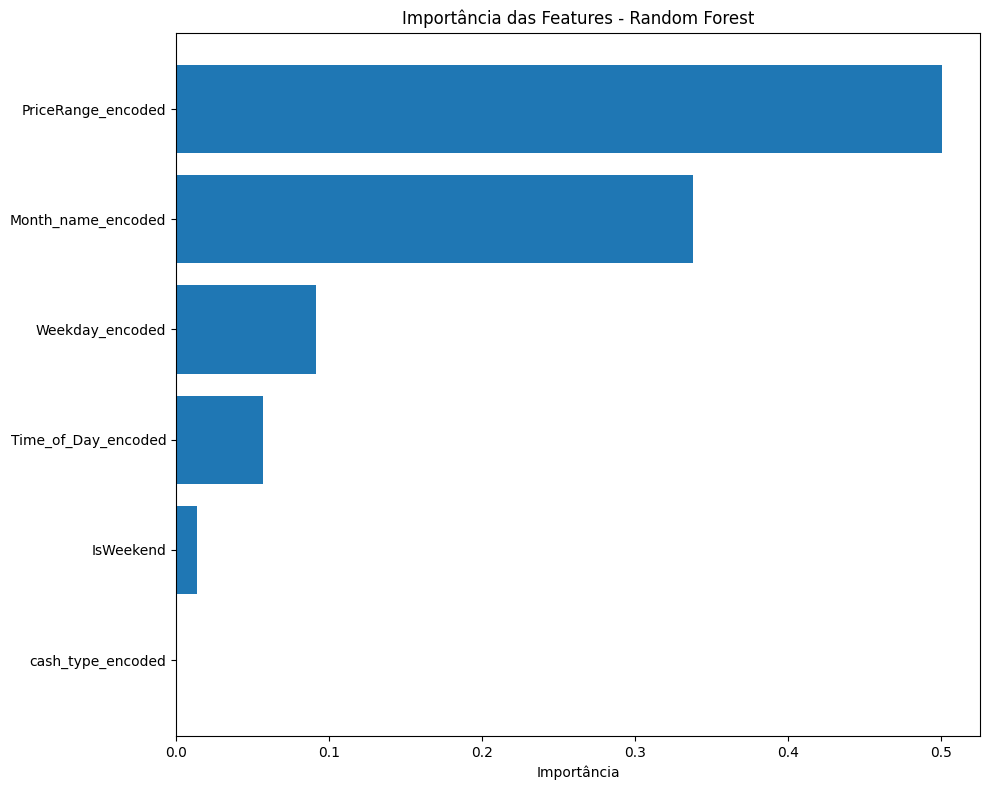

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)
rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)

print(f"Random Forest - Acurácia: {rf_accuracy:.4f}")

feature_importance = pd.DataFrame({
    'feature': available_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeatures mais importantes:")
print(feature_importance.head(10))

plt.figure(figsize=(10, 8))
top_features = feature_importance.head(10)
plt.barh(top_features['feature'], top_features['importance'])
plt.title('Importância das Features - Random Forest')
plt.xlabel('Importância')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 5. Comparação e Avaliação dos Modelos

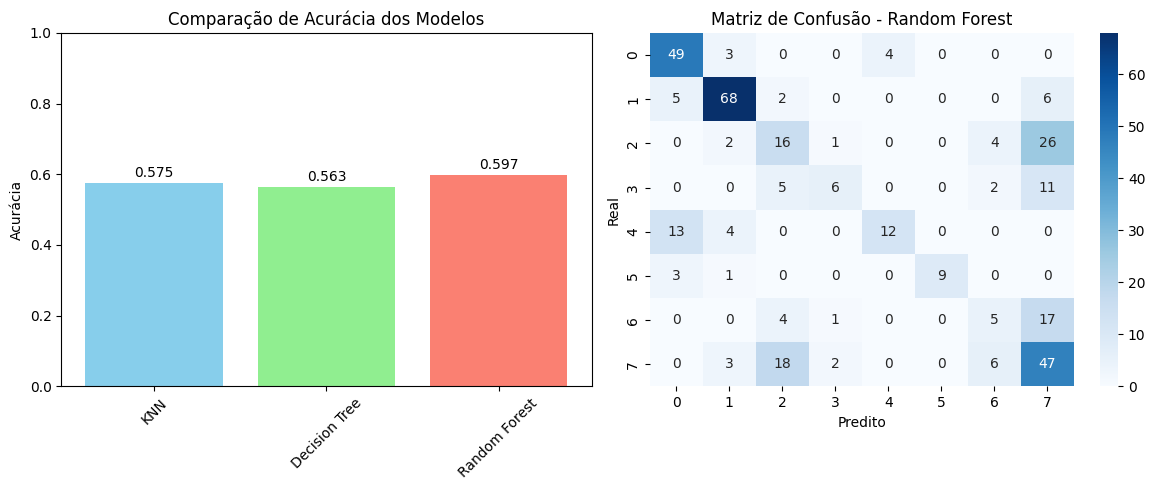

Melhor modelo: Random Forest com acurácia de 0.5972


In [13]:
models_results = {
    'KNN': {'accuracy': knn_accuracy, 'predictions': knn_predictions},
    'Decision Tree': {'accuracy': dt_accuracy, 'predictions': dt_predictions},
    'Random Forest': {'accuracy': rf_accuracy, 'predictions': rf_predictions}
}

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
models = list(models_results.keys())
accuracies = [models_results[model]['accuracy'] for model in models]

bars = plt.bar(models, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Comparação de Acurácia dos Modelos')
plt.ylabel('Acurácia')
plt.ylim(0, 1)

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{acc:.3f}', ha='center', va='bottom')

plt.xticks(rotation=45)

best_model_name = max(models_results.keys(), key=lambda x: models_results[x]['accuracy'])
best_predictions = models_results[best_model_name]['predictions']

plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusão - {best_model_name}')
plt.xlabel('Predito')
plt.ylabel('Real')

plt.tight_layout()
plt.show()

print(f"Melhor modelo: {best_model_name} com acurácia de {models_results[best_model_name]['accuracy']:.4f}")

## 5.1 Relatórios Detalhados de Classificação

In [14]:
for model_name, results in models_results.items():
    print(f"\n{model_name.upper()}")
    print("-" * 50)
    print(classification_report(y_test, results['predictions']))
    print("\nMatriz de Confusão:")
    cm = confusion_matrix(y_test, results['predictions'])
    cm_df = pd.DataFrame(cm, index=np.unique(y_test), columns=np.unique(y_test))
    cm_df


KNN
--------------------------------------------------
                     precision    recall  f1-score   support

          Americano       0.72      0.82      0.77        56
Americano with Milk       0.70      0.85      0.77        81
         Cappuccino       0.38      0.47      0.42        49
              Cocoa       0.40      0.42      0.41        24
            Cortado       0.56      0.34      0.43        29
           Espresso       1.00      0.54      0.70        13
      Hot Chocolate       0.19      0.11      0.14        27
              Latte       0.55      0.47      0.51        76

           accuracy                           0.57       355
          macro avg       0.56      0.50      0.52       355
       weighted avg       0.57      0.57      0.56       355


Matriz de Confusão:

DECISION TREE
--------------------------------------------------
                     precision    recall  f1-score   support

          Americano       0.61      0.91      0.73        56

## 5.2 Exemplo de Predição

In [15]:
if len(X_test) > 0:
    sample_idx = 0
    sample_data = X_test.iloc[sample_idx:sample_idx+1]
    real_coffee = y_test.iloc[sample_idx]
    
    print(f"\nDados da amostra:")
    for feature, value in zip(available_features, sample_data.iloc[0]):
        print(f"   {feature}: {value}")
    
    print(f"\n Tipo real: {real_coffee}")
    print("\n Predições dos modelos:")
    
    sample_scaled = scaler.transform(sample_data)
    knn_pred = knn_model.predict(sample_scaled)[0]
    knn_proba = max(knn_model.predict_proba(sample_scaled)[0])
    print(f"   KNN: {knn_pred} (confiança: {knn_proba:.3f})")
    
    dt_pred = dt_model.predict(sample_data)[0]
    dt_proba = max(dt_model.predict_proba(sample_data)[0])
    print(f"   Decision Tree: {dt_pred} (confiança: {dt_proba:.3f})")
    
    rf_pred = rf_model.predict(sample_data)[0]
    rf_proba = max(rf_model.predict_proba(sample_data)[0])
    print(f"   Random Forest: {rf_pred} (confiança: {rf_proba:.3f})")
    
    print("\n Resultados:")
    models_pred = {'KNN': knn_pred, 'Decision Tree': dt_pred, 'Random Forest': rf_pred}
    for model, pred in models_pred.items():
        status = "CORRETO" if pred == real_coffee else "INCORRETO"
        print(f"   {model}: {status}")


Dados da amostra:
   cash_type_encoded: 0
   Time_of_Day_encoded: 0
   Weekday_encoded: 4
   Month_name_encoded: 7
   IsWeekend: 0
   PriceRange_encoded: 0

 Tipo real: Americano with Milk

 Predições dos modelos:
   KNN: Americano with Milk (confiança: 0.400)
   Decision Tree: Americano with Milk (confiança: 0.667)
   Random Forest: Americano with Milk (confiança: 0.339)

 Resultados:
   KNN: CORRETO
   Decision Tree: CORRETO
   Random Forest: CORRETO
